In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
import matplotlib.pyplot as plt
import numpy as np
import kagglehub

2025-08-22 02:47:28.329695: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755830848.533815      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755830848.603954      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
path = kagglehub.dataset_download("kmader/food41")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/food41


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [5]:
train_dataset = image_dataset_from_directory(
    f"{path}/images",
    labels='inferred',
    validation_split=0.2, # 전체 데이터의 20%를 검증용으로 사용
    subset='training',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = image_dataset_from_directory(
    f"{path}/images",
    labels='inferred',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

Found 101000 files belonging to 101 classes.
Using 80800 files for training.


I0000 00:00:1755830946.115765      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755830946.116426      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 101000 files belonging to 101 classes.
Using 20200 files for validation.


In [6]:
class_names = train_dataset.class_names
num_classes = len(class_names)
print(f"총 {num_classes}개의 클래스가 준비되었습니다.")

총 101개의 클래스가 준비되었습니다.


In [8]:
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [9]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5), # 학습률을 0.00001로 설정
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)
epochs = 20


callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
]

In [ ]:
history= model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs2,
    callbacks=callbacks
)

Epoch 1/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 311s 123ms/step - accuracy: 0.2780 - loss: 3.3834 - val_accuracy: 0.5018 - val_loss: 2.0764
Epoch 2/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 288s 114ms/step - accuracy: 0.5298 - loss: 1.9207 - val_accuracy: 0.5988 - val_loss: 1.6052
Epoch 3/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 288s 114ms/step - accuracy: 0.6156 - loss: 1.5185 - val_accuracy: 0.6412 - val_loss: 1.4099
Epoch 4/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 288s 114ms/step - accuracy: 0.6625 - loss: 1.3057 - val_accuracy: 0.6635 - val_loss: 1.3050
Epoch 5/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 287s 114ms/step - accuracy: 0.6996 - loss: 1.1566 - val_accuracy: 0.6816 - val_loss: 1.2271
Epoch 6/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 286s 113ms/step - accuracy: 0.7246 - loss: 1.0393 - val_accuracy: 0.6934 - val_loss: 1.1776
Epoch 7/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 285s 113ms/step - accuracy: 0.7491 - loss: 0.9436 - val_accuracy: 0.7008 - val_loss: 1.1440
Epoch 8/20
2525/2525 ━━━━━━━━━━━━━━━━━━━━ 285s 113ms/step - ac

In [ ]:
val_loss, val_acc=model.evaluate(validation_dataset)
print(f"테스트 데이터셋의 손실(Loss): {val_loss:.4f}")
print(f"테스트 데이터셋의 정확도(Accuracy): {val_acc:.4f}")

632/632 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.7171 - loss: 1.0922
테스트 데이터셋의 손실(Loss): 1.0831
테스트 데이터셋의 정확도(Accuracy): 0.7177


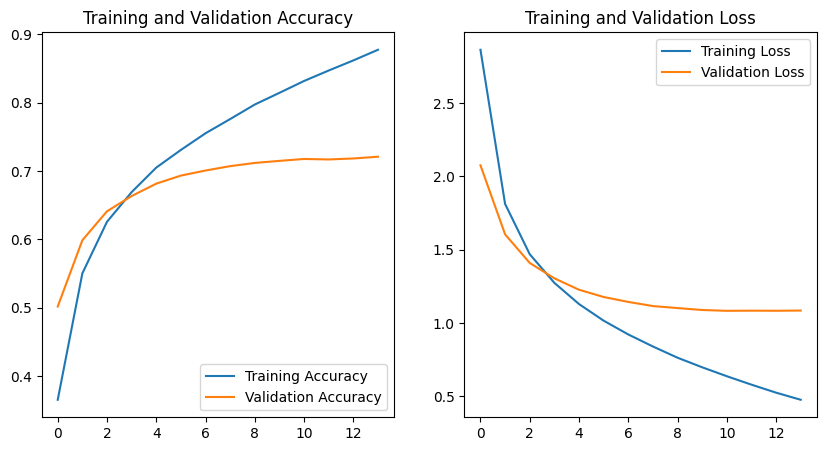

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [15]:
model.save('food_classifier_mbnetv2.h5')

In [ ]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"), 
    tf.keras.layers.RandomRotation(0.2), 
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.2), 
])

### 데이터 증강 추가

In [ ]:
IMG_SIZE = 224
num_classes = 101

base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = True

In [ ]:
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = base_model(x, training=True)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)

x = Dropout(0.5)(x) 
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=inputs, outputs=predictions)


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
epochs= 20
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )
]

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=callbacks
)